In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import data
data_path = '/content/predictive_maintenance_svm.csv'
data = pd.read_csv(data_path)
n = data.shape[0]
print('Features non-null values and data type:')
data.info()
print('Check for duplicate values:',
      data['Product ID'].unique().shape[0]!=n)

Features non-null values and data type:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
Check for duplicate values: False


In [74]:
# Set numeric columns dtype to float
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')
# Rename features
data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

In [75]:
# Remove first character and set to numeric dtype
data['Product ID'] = data['Product ID'].apply(lambda x: x[1:])
data['Product ID'] = pd.to_numeric(data['Product ID'])
# Drop ID columns
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)
value = data['Type'].value_counts()
Type_percentage = 100*value/data.Type.shape[0]
labels = Type_percentage.index.array
x = Type_percentage.array

In [76]:
# Create lists of features and target names
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Portion of data where RNF=1
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [77]:
first_drop = df.loc[idx_RNF,target].shape[0]
df.drop(index=idx_RNF, inplace=True)
# Portion of data where Machine failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
# print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)
df.reset_index(drop=True, inplace=True)   # Reset index
n = df.shape[0]

,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [78]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
num_features = [feature for feature in features if df[feature].dtype=='float64']
df_pre[num_features] = sc.fit_transform(df_pre[num_features]) 
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]


In [80]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features]) 

In [82]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import time

# train-validation-test split
X, y = df_pre[features], df_pre[['Target','Failure Type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=df_pre['Failure Type'], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['Failure Type'], random_state=0)

In [83]:
def eval_preds(model,X,y_true,y_pred,task):
    if task == 'binary':
        # Extract task target
        y_true = y_true['Target']
        cm = confusion_matrix(y_true, y_pred)
        # Probability of the minority class
        proba = model.predict_proba(X)[:,1]
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
    elif task == 'multi_class':
        y_true = y_true['Failure Type']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2})
    metrics = round(metrics,3)
    return cm, metrics



def tune_and_fit(clf,X,y,params,task):
    if task=='binary':
        f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                                cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Target'])
    elif task=='multi_class':
        f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                              cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Failure Type'])
        
    print('Best params:', grid_model.best_params_)
    # Print training times
    train_time = time.time()-start_time
    mins = int(train_time//60)
    print('Training time: '+str(mins)+'m '+str(round(train_time-mins*60))+'s')
    return grid_model


In [84]:
def predict_and_evaluate(fitted_models,X,y_true,clf_str,task):
    cm_dict = {key: np.nan for key in clf_str}
    metrics = pd.DataFrame(columns=clf_str)
    y_pred = pd.DataFrame(columns=clf_str)
    for fit_model, model_name in zip(fitted_models,clf_str):
        # Update predictions
        y_pred[model_name] = fit_model.predict(X)
        # Metrics
        if task == 'binary':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        elif task == 'multi_class':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        # Update Confusion matrix and metrics
        cm_dict[model_name] = cm
        metrics[model_name] = scores
    return y_pred, cm_dict, metrics


def fit_models(clf,clf_str,X_train,X_val,y_train,y_val):
    metrics = pd.DataFrame(columns=clf_str)
    for model, model_name in zip(clf, clf_str):
        model.fit(X_train,y_train['Target'])
        y_val_pred = model.predict(X_val)
        metrics[model_name] = eval_preds(model,X_val,y_val,y_val_pred,'binary')[1]
    return metrics


In [85]:
svc = SVC(probability=True)
clf = [svc]
clf_str = ['SVC'] 

# Fit on raw train
metrics_0 = fit_models(clf,clf_str,X_train,X_val,y_train,y_val)

# Fit on temperature product train
XX_train = X_train.drop(columns=['Process temperature','Air temperature'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature']= X_val['Process temperature']-X_val['Air temperature']
metrics_1 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on power product train
XX_train = X_train.drop(columns=['Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Rotational speed','Torque'])
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']     
metrics_2 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on both products train
XX_train = X_train.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature']= X_val['Process temperature']*X_val['Air temperature']
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']       
metrics_3 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)


In [86]:
cm_labels = ['Not Failure', 'Failure']

In [90]:
svc_linear = SVC(kernel='linear')
svc_rbf = SVC(kernel='rbf')
svc_sig = SVC(kernel='sigmoid')

clf = [svc_linear, svc_rbf, svc_sig]
clf_str = ['SVC linear', 'SVC rbf', 'SVC Sigmoid']

svc_params1 = {'C': [1, 10, 100],
              'kernel': ['linear'],
              'probability':[True],
              'random_state':[0]}

svc_params2 = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}

# svc_params3 = {'C': [1, 10, 100],
#               'degree': [2,3,4],
#               'kernel': ['poly'],
#               'probability':[True],
#               'random_state':[0]}

svc_params3 = {'C': [1, 10, 100],
              'kernel': ['sigmoid'],
              'gamma': [0.1, 1],
              'coef0': [0, 1, 2],
              'probability': [True],
              'random_state': [0]}

params1 = pd.Series(data=[svc_params1, svc_params2, svc_params3],
                   index=clf)

fitted_models_binary = []
for model1, model_name1 in zip(clf, clf_str):
    print('Training '+str(model_name1))
    fit_model = tune_and_fit(model1,X_train,y_train,params1[model1],'binary')
    fitted_models_binary.append(fit_model)


Training SVC linear
Best params: {'C': 1, 'kernel': 'linear', 'probability': True, 'random_state': 0}
Training time: 5m 20s
Training SVC rbf
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 1m 50s
Training SVC Sigmoid
Best params: {'C': 100, 'coef0': 0, 'gamma': 0.1, 'kernel': 'sigmoid', 'probability': True, 'random_state': 0}
Training time: 19m 24s


In [72]:
svc = SVC()
clf = [svc]
clf_str = ['SVC']
svc_params1 = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
params1 = pd.Series(data=[svc_params1],
                   index=clf)
fitted_models_binary = []
for model1, model_name1 in zip(clf, clf_str):
    print('Training '+str(model_name1))
    fit_model = tune_and_fit(model1,X_train,y_train,params1[model1],'binary')
    fitted_models_binary.append(fit_model)


Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 1m 50s


In [ ]:
svc = SVC()
clf = [svc]
clf_str = ['SVC']
svc_params2 = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['poly'],
              'probability':[True],
              'random_state':[0]}
params2 = pd.Series(data=[svc_params2],
                   index=clf)
fitted_models_binary = []
for model2, model_name2 in zip(clf, clf_str):
    print('Training '+str(model_name2))
    fit_model = tune_and_fit(model2,X_train,y_train,params2[model2],'binary')
    fitted_models_binary.append(fit_model)

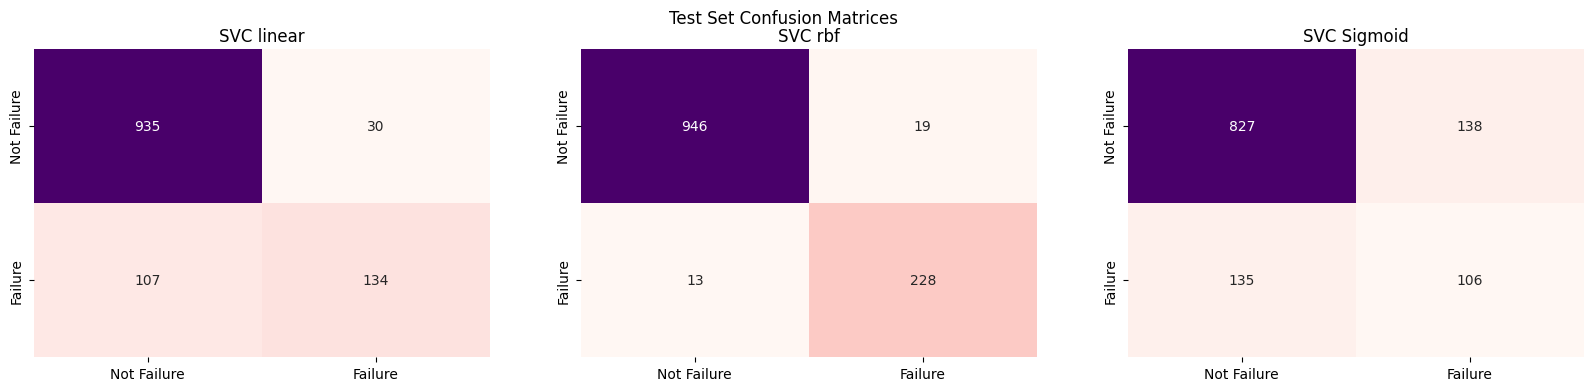


Validation scores:
     SVC linear  SVC rbf  SVC Sigmoid
ACC       0.886    0.966        0.791
AUC       0.899    0.987        0.303
F1        0.678    0.916        0.484
F2        0.628    0.931        0.488
Test scores:
     SVC linear  SVC rbf  SVC Sigmoid
ACC       0.886    0.973        0.774
AUC       0.911    0.992        0.326
F1        0.662    0.934        0.437
F2        0.594    0.941        0.439


In [102]:
# Create evaluation metrics
task = 'binary'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_binary,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_binary,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
# fig, axs = plt.subplots(ncols=3, figsize=(20,4))

# fig.suptitle('Validation Set Confusion Matrices')
# for j, model_name in enumerate(clf_str):
#     ax = axs[j]
#     sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
#                 fmt='d', cmap='RdPu', cbar=False)
#     ax.title.set_text(model_name)
#     ax.set_xticklabels(cm_labels)
#     ax.set_yticklabels(cm_labels)
# plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=3, figsize=(20,4))

fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='RdPu', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')